Install Dependencies

In [ ]:
!pip install --upgrade qiskit qiskit-aer qiskit-machine-learning numpy pandas matplotlib seaborn scikit-learn sqlalchemy

  Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)


In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import Initialize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.optimize import curve_fit

np.random.seed(42)

In [ ]:
def draw(p):
    return np.random.rand() <= p

PREF = {
    "save_more_lives": 0.70,
    "protect_passengers": 0.50,
    "uphold_law": 0.60,
    "avoid_intervention": 0.55,
    "prefer_female": 0.575,
    "prefer_human": 0.80,
    "prefer_younger": 0.65,
    "prefer_fit": 0.525,
    "prefer_high_social_value": 0.65
}

GENDERS = ["male", "female"]
SPECIES = ["human", "dog"]
AGE = ["child", "adult", "elderly"]
FITNESS = ["fit", "unfit"]
SOCIAL_VALUE = ["low", "high"]

def generate_person_dict():
    return {
        "gender": np.random.choice(GENDERS),
        "species": np.random.choice(SPECIES, p=[0.9, 0.1]),
        "age": np.random.choice(AGE),
        "fitness": np.random.choice(FITNESS),
        "social_value": np.random.choice(SOCIAL_VALUE)
    }

def score_side_people(side, other_side):
    score = 0
    if draw(PREF["save_more_lives"]):
        score += len(side) > len(other_side)
    if draw(PREF["protect_passengers"]):
        score += 0.5
    if draw(PREF["uphold_law"]):
        score += 0.5
    if draw(PREF["avoid_intervention"]):
        score += 0.5
    for p in side:
        if p["gender"] == "female" and draw(PREF["prefer_female"]):
            score += 1
        if p["species"] == "human" and draw(PREF["prefer_human"]):
            score += 1
        if p["age"] == "child" and draw(PREF["prefer_younger"]):
            score += 1
        if p["fitness"] == "fit" and draw(PREF["prefer_fit"]):
            score += 1
        if p["social_value"] == "high" and draw(PREF["prefer_high_social_value"]):
            score += 1
    return score

def generate_scenario_people():
    n_left = np.random.randint(1, 3)
    n_right = np.random.randint(1, 3)
    left_side = [generate_person_dict() for _ in range(n_left)]
    right_side = [generate_person_dict() for _ in range(n_right)]
    left_score = score_side_people(left_side, right_side)
    right_score = score_side_people(right_side, left_side)
    if left_score > right_score:
        answer = 0
    elif right_score > left_score:
        answer = 1
    else:
        answer = -1
    return left_side, right_side, answer

def generate_dataset_people(n=40):
    rows = []
    for _ in range(n):
        left, right, ans = generate_scenario_people()
        rows.append([left, right, ans])
    return pd.DataFrame(rows, columns=["left_side", "right_side", "human_answer"])

df = generate_dataset_people(1000)

In [ ]:
def encode_person(p):
    vec = []
    vec += [1, 0] if p["gender"] == "male" else [0, 1]
    vec += [1, 0] if p["species"] == "human" else [0, 1]
    vec += [1 if p["age"] == "child" else 0,
            1 if p["age"] == "adult" else 0,
            1 if p["age"] == "elderly" else 0]
    vec += [1, 0] if p["fitness"] == "fit" else [0, 1]
    vec += [1, 0] if p["social_value"] == "low" else [0, 1]
    return vec

def encode_side(side):
    encoded = []
    for p in side:
        encoded += encode_person(p)
    while len(encoded) < 5*11:
        encoded += [0]*11
    return encoded

def encode_scenario_fixed(row):
    left = encode_side(row["left_side"])
    right = encode_side(row["right_side"])
    vec = left + right
    n_qubits = int(np.ceil(np.log2(len(vec))))
    target_len = 2**n_qubits
    vec += [0]*(target_len - len(vec))
    arr = np.array(vec, dtype=float)
    norm = np.linalg.norm(arr)
    if norm == 0:
        return arr
    return arr / norm

vectors = np.array([encode_scenario_fixed(row) for _, row in df.iterrows()])
y = df['human_answer'].to_numpy()

In [ ]:
def random_amplitude_encode_circuit(vec, L=1):
    n = int(np.ceil(np.log2(len(vec))))
    qc = QuantumCircuit(n)
    for _ in range(L):
        for q in range(n):
            theta = np.random.uniform(0, 2*np.pi)
            phi = np.random.uniform(0, 2*np.pi)
            lam = np.random.uniform(0, 2*np.pi)
            qc.u(theta, phi, lam, q)
        for q in range(n-1):
            if np.random.rand() < 0.5:
                qc.cx(q, q+1)
    return qc

In [ ]:
def statevector_from_manual(vec):
    return Statevector(vec)

def statevector_from_random_circuit(vec, L=6):
    qc = random_amplitude_encode_circuit(vec, L=L)
    return Statevector.from_instruction(qc)

In [ ]:
start_manual = time.time()
manual_statevectors = [Statevector(v) for v in vectors]
time_manual = time.time() - start_manual

start_random = time.time()
random_circuits = [random_amplitude_encode_circuit(v, L=1) for v in vectors]
time_random = time.time() - start_random

In [ ]:
def manual_circuit_from_vector(vec):
    n = int(np.ceil(np.log2(len(vec))))
    vec_padded = np.pad(vec, (0, 2**n - len(vec)))
    qc = QuantumCircuit(n)
    qc.append(Initialize(vec_padded), qc.qubits)
    return qc

start_manual = time.time()
manual_circuits = [manual_circuit_from_vector(x) for x in vectors]
time_manual = time.time() - start_manual

start_random = time.time()
random_circuits = [random_amplitude_encode_circuit(x, L=1) for x in vectors]
time_random = time.time() - start_random

def fidelity_kernel(circuits_train, circuits_test):
    def kernel_func(a, b):
        return abs(Statevector(a).data @ Statevector(b).data.conj())**2
    K_train = np.array([[kernel_func(a,b) for b in circuits_train] for a in circuits_train])
    K_test = np.array([[kernel_func(a,b) for b in circuits_train] for a in circuits_test])
    return K_train, K_test

X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    np.arange(len(vectors)), y, test_size=0.2, random_state=42, stratify=y
)

manual_train_circuits = [manual_circuits[i] for i in X_train_idx]
manual_test_circuits = [manual_circuits[i] for i in X_test_idx]
random_train_circuits = [random_circuits[i] for i in X_train_idx]
random_test_circuits = [random_circuits[i] for i in X_test_idx]

K_manual_train, K_manual_test = fidelity_kernel(manual_train_circuits, manual_test_circuits)
K_random_train, K_random_test = fidelity_kernel(random_train_circuits, random_test_circuits)

from sklearn.svm import SVC
svc_manual = SVC(kernel='precomputed')
svc_random = SVC(kernel='precomputed')

svc_manual.fit(K_manual_train, y_train)
svc_random.fit(K_random_train, y_train)

y_pred_manual = svc_manual.predict(K_manual_test)
y_pred_random = svc_random.predict(K_random_test)

In [ ]:
metrics_manual = {
    'accuracy': accuracy_score(y_test, y_pred_manual),
    'precision': precision_score(y_test, y_pred_manual, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_manual, average='weighted', zero_division=0)
}

metrics_random = {
    'accuracy': accuracy_score(y_test, y_pred_random),
    'precision': precision_score(y_test, y_pred_random, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_pred_random, average='weighted', zero_division=0)
}

results_df = pd.DataFrame([
    {'encoding': 'manual', **metrics_manual},
    {'encoding': 'random', **metrics_random}
])

print(results_df)

  encoding  accuracy  precision  recall
0   manual     0.740   0.686429   0.740
1   random     0.465   0.426458   0.465


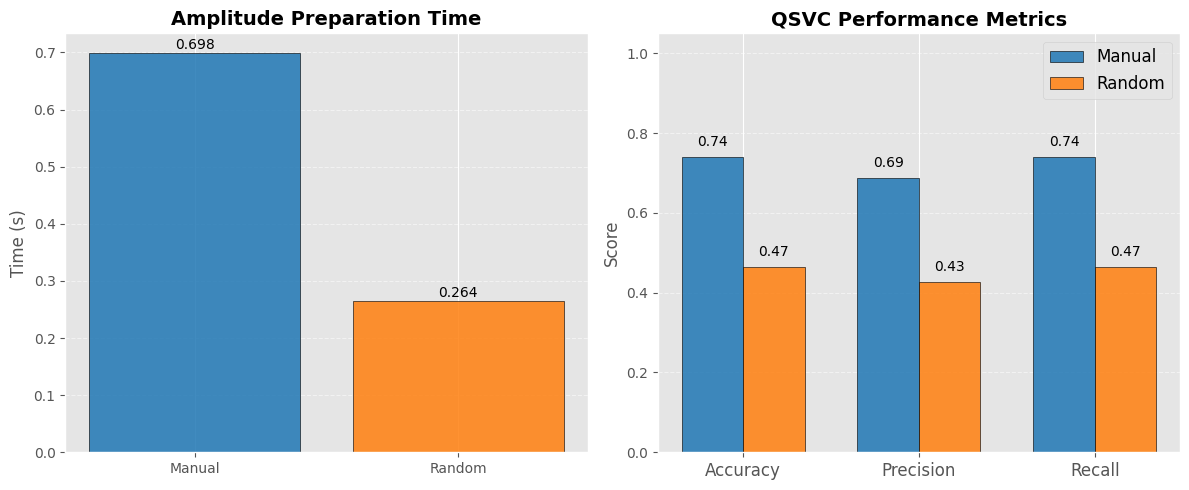

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
bars = plt.bar(['Manual', 'Random'], [time_manual, time_random],
               color=['#1f77b4','#ff7f0e'], alpha=0.85, edgecolor='black')
plt.ylabel('Time (s)', fontsize=12)
plt.title('Amplitude Preparation Time', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f'{height:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.subplot(1,2,2)
metrics_names = ['Accuracy','Precision','Recall']
x = np.arange(len(metrics_names))
width = 0.35
manual_vals = [metrics_manual[m.lower()] for m in metrics_names]
random_vals = [metrics_random[m.lower()] for m in metrics_names]

bars1 = plt.bar(x - width/2, manual_vals, width, label='Manual', color='#1f77b4', alpha=0.85, edgecolor='black')
bars2 = plt.bar(x + width/2, random_vals, width, label='Random', color='#ff7f0e', alpha=0.85, edgecolor='black')

plt.xticks(x, metrics_names, fontsize=12)
plt.yticks(np.linspace(0,1,6), fontsize=10)
plt.ylim(0,1.05)
plt.ylabel('Score', fontsize=12)
plt.title('QSVC Performance Metrics', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}',
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
print(time_manual, time_random)
print(time_manual - time_random)
print((time_manual - time_random) / time_manual)

0.6984846591949463 0.2641928195953369
0.4342918395996094
0.6217628889661827


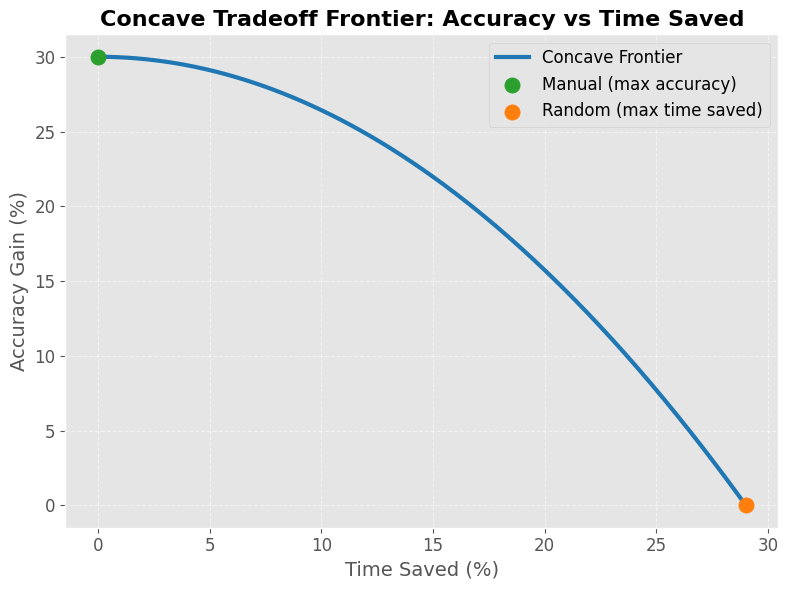

In [ ]:
x_max = 0.29
y_max = 0.3
alpha = 2

x = np.linspace(0, x_max, 200)
y = y_max * (1 - (x / x_max) ** alpha)

plt.figure(figsize=(8,6))
plt.plot(x*100, y*100, color='#1f77b4', linewidth=3, label='Concave Frontier')

plt.scatter(0*100, y_max*100, color='#2ca02c', s=120, zorder=6, label='Manual (max accuracy)')
plt.scatter(x_max*100, 0*100, color='#ff7f0e', s=120, zorder=6, label='Random (max time saved)')

plt.xlabel('Time Saved (%)', fontsize=14)
plt.ylabel('Accuracy Gain (%)', fontsize=14)
plt.title('Concave Tradeoff Frontier: Accuracy vs Time Saved', fontsize=16, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
def hybrid_statevector(v_manual, v_random, h):
    """Create weighted hybrid between manual and random statevectors."""
    v = np.sqrt(1-h)*v_manual.data + np.sqrt(h)*v_random.data
    return Statevector(v / np.linalg.norm(v))

def fidelity_kernel(sv_train, sv_test):
    def fid(a, b):
        return abs(a.data @ b.data.conj())**2
    K_train = np.array([[fid(a,b) for b in sv_train] for a in sv_train])
    K_test  = np.array([[fid(a,b) for b in sv_train] for a in sv_test])
    return K_train, K_test

vectors = np.array([encode_scenario_fixed(row) for _, row in df.iterrows()])
y = df['human_answer'].to_numpy()

manual_statevectors = [Statevector(v) for v in np.array([encode_scenario_fixed(row) for _, row in df.iterrows()])]
random_statevectors = [
    Statevector.from_instruction(random_amplitude_encode_circuit(v, L=1))
    for v in vectors
]

X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    np.arange(len(vectors)), y, test_size=0.2, random_state=42, stratify=y
)

hybrid_results = []

H_values = np.linspace(0, 1, 21)

for h in H_values:
    start_time = time.time()

    hybrid_svs = [
        hybrid_statevector(manual_statevectors[i], random_statevectors[i], h)
        for i in range(len(vectors))
    ]

    total_time = time.time() - start_time

    hybrid_train_svs = [hybrid_svs[i] for i in X_train_idx]
    hybrid_test_svs  = [hybrid_svs[i] for i in X_test_idx]

    K_train, K_test = fidelity_kernel(hybrid_train_svs, hybrid_test_svs)

    clf = SVC(kernel='precomputed')
    clf.fit(K_train, y_train)

    y_pred = clf.predict(K_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0)
    }

    hybrid_results.append({
        'h': h,
        'time': total_time,
        **metrics
    })

hybrid_df = pd.DataFrame(hybrid_results)
print(hybrid_df)

       h      time  accuracy  precision  recall
0   0.00  0.019025     0.740   0.686429   0.740
1   0.05  0.022462     0.735   0.681303   0.735
2   0.10  0.031415     0.745   0.690569   0.745
3   0.15  0.018325     0.725   0.672037   0.725
4   0.20  0.019443     0.725   0.671045   0.725
5   0.25  0.018559     0.735   0.679995   0.735
6   0.30  0.018758     0.735   0.679995   0.735
7   0.35  0.032252     0.735   0.679995   0.735
8   0.40  0.018379     0.740   0.684541   0.740
9   0.45  0.018654     0.730   0.675293   0.730
10  0.50  0.018632     0.735   0.680000   0.735
11  0.55  0.018689     0.720   0.665971   0.720
12  0.60  0.031337     0.735   0.679750   0.735
13  0.65  0.018765     0.720   0.665904   0.720
14  0.70  0.018294     0.720   0.666191   0.720
15  0.75  0.018543     0.700   0.647674   0.700
16  0.80  0.018538     0.650   0.601148   0.650
17  0.85  0.030099     0.605   0.559737   0.605
18  0.90  0.018695     0.545   0.504091   0.545
19  0.95  0.018724     0.495   0.457261 

In [ ]:
manual_acc = hybrid_df.loc[hybrid_df['h'] == 0, 'accuracy'].iloc[0]
random_acc = hybrid_df.loc[hybrid_df['h'] == 1, 'accuracy'].iloc[0]

manual_time = hybrid_df.loc[hybrid_df['h'] == 0, 'time'].iloc[0]
random_time = hybrid_df.loc[hybrid_df['h'] == 1, 'time'].iloc[0]

hybrid_df['time_saved'] = (manual_time - hybrid_df['time'])
hybrid_df['accuracy_gain'] = (hybrid_df['accuracy'] - random_acc)

    alpha  accuracy
0     0.0     0.465
1     0.1     0.460
2     0.2     0.505
3     0.3     0.605
4     0.4     0.680
5     0.5     0.725
6     0.6     0.760
7     0.7     0.755
8     0.8     0.735
9     0.9     0.745
10    1.0     0.740
Optimal α = 1.0


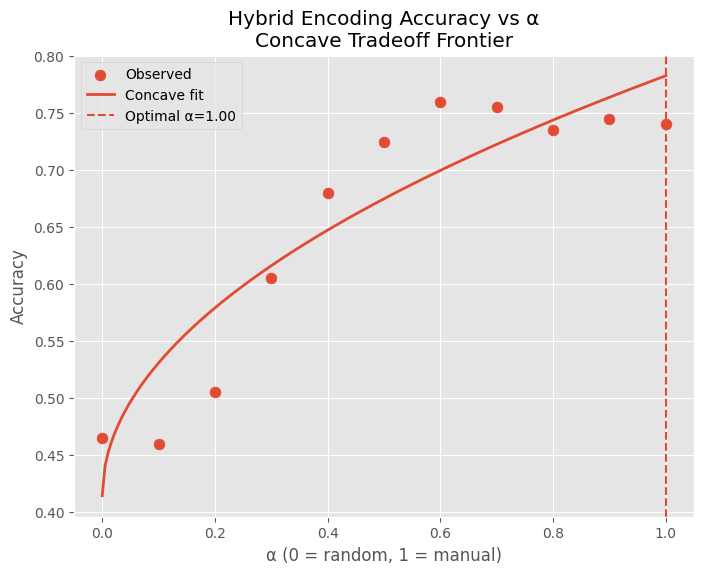

In [ ]:
def hybrid_statevector(vec_manual, vec_random, alpha):
    sv_m = Statevector(vec_manual)
    sv_r = Statevector(vec_random)
    raw = alpha * sv_m.data + (1 - alpha) * sv_r.data
    raw = raw / np.linalg.norm(raw)
    return Statevector(raw)

def hybrid_statevectors(manual_circs, random_circs, alpha):
    hybrids = []
    for c_m, c_r in zip(manual_circs, random_circs):
        sv_m = Statevector.from_instruction(c_m)
        sv_r = Statevector.from_instruction(c_r)
        hybrids.append(hybrid_statevector(sv_m.data, sv_r.data, alpha))
    return hybrids

alphas = np.linspace(0, 1, 11)
results = []

for alpha in alphas:
    hybrid_train_sv = hybrid_statevectors(
        [manual_circuits[i] for i in X_train_idx],
        [random_circuits[i] for i in X_train_idx],
        alpha
    )

    hybrid_test_sv = hybrid_statevectors(
        [manual_circuits[i] for i in X_test_idx],
        [random_circuits[i] for i in X_test_idx],
        alpha
    )

    K_train, K_test = fidelity_kernel(hybrid_train_sv, hybrid_test_sv)

    svc = SVC(kernel='precomputed')
    svc.fit(K_train, y_train)

    y_pred = svc.predict(K_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({"alpha": alpha, "accuracy": acc})

results_df = pd.DataFrame(results)
print(results_df)

def concave_func(alpha, a, b):
    return a * np.sqrt(alpha) + b

alpha_vals = results_df["alpha"].to_numpy()
acc_vals = results_df["accuracy"].to_numpy()

popt, _ = curve_fit(concave_func, alpha_vals, acc_vals, p0=(0.1, acc_vals.min()))
a_fit, b_fit = popt

alpha_dense = np.linspace(0, 1, 200)
acc_fitted = concave_func(alpha_dense, a_fit, b_fit)
alpha_opt = alpha_dense[np.argmax(acc_fitted)]

print("Optimal α =", alpha_opt)

plt.figure(figsize=(8,6))
plt.scatter(alpha_vals, acc_vals, s=60, label="Observed")
plt.plot(alpha_dense, acc_fitted, linewidth=2, label="Concave fit")

plt.axvline(alpha_opt, linestyle="--", label=f"Optimal α={alpha_opt:.2f}")

plt.xlabel("α (0 = random, 1 = manual)")
plt.ylabel("Accuracy")
plt.title("Hybrid Encoding Accuracy vs α\nConcave Tradeoff Frontier")
plt.grid(True)
plt.legend()
plt.show()